In [1]:
import glob

import xarray as xr
import pandas as pd
import numpy as np

# cognac data and tools
import cognac.insitu as insi

---
## load and process data

In [2]:
# select campaign

#campaign = 'microco_leg2.yaml'
#campaign = 'lopstech19_leg1.yaml'
#campaign = 'lopstech19_leg2.yaml'
campaign = 'cognac20.yaml'

cp = insi.utils.campaign(campaign)

In [3]:
# load ship data
df = xr.open_dataset(cp.pathp+'ship.nc').to_dataframe()
#df.head()

In [6]:
# utils

def read_adcp(adcp_file, 
              nbins=80, 
              first_bin_z=-16.48,
              bin_size=8.,
              resampling=None
             ):
    
    cols = ['Ens','YR', 'MO', 'DA', 'HH', 'MM', 'SS', 'HHbis']
    V = ['East', 'North', 'Ver', 'Err', 'PG4']
    for v in V:
        cols += [v+'_{}'.format(b) for b in range(nbins)]
    cols += ['NVE', 'NVN', 'FLat', 'FLon', 'LLat', 'LLon']
    
    df = pd.read_csv(adcp_file,
                     sep='\t', 
                     skiprows=16, 
                     names=cols,
                     decimal=',',
                     index_col=False,
                     )
    
    #print(df)
    #df0 = df.iloc[0]
    ##print(df0['East_0'])
    #print(df0['Err_75'])
    #print(df0['PG4_0'])
    #print(df0['PG4_79'])
    #df['PG4_1'].plot()

    df['time'] = pd.Series(
                            [pd.Timestamp(year=int(2000+row['YR']), 
                              month=int(row['MO']),
                              day=int(row['DA']),
                              hour=int(row['HH']),
                              minute=int(row['MM']),
                              second=int(row['SS']),
                             ) for _,row in df.iterrows()]
                        )
    df = df.set_index('time')
    
    if resampling is not None:
        df = df.resample(resampling).mean()
    
    # change
    df1 = pd.concat([pd.concat([df[v+'_{}'.format(b)].rename(first_bin_z - (b-1)*bin_size) 
                                for b in range(nbins)
                               ], 
                              axis=1
                             ).stack()
                              .rename(v)
                    for v in V],
                   axis=1,
                  )
    ds = df1.to_xarray().rename_dims(level_1='z').transpose()
    ds = ds.rename(level_1='z')
    
    V1d = ['NVE', 'NVN', 'FLat', 'FLon', 'LLat', 'LLon']
    ds = ds.assign({v: df[v] for v in V1d}).reset_coords(V1d)
    
    ds['East'] = ds['East']/1e3
    ds['North'] = ds['North']/1e3
    
    return ds


def plot_current(df, lims=None, scale=10):

    if lims==0:
        ll_lims = [6.3, 6.8, 42.75, 43.2]
    else:
        ll_lims = [7., 7.3, 43.3, 43.5]
    
    x, y, u, v = df['FLon'], df['FLat'], df['Eas'], df['Nor']
    fac = insi.utils.plot_map(cp=cp, ll_lim=ll_lims)
    insi.utils.plot_bathy(fac)
    q = fac[1].quiver(x, y, u, v, transform=fac[2], scale=scale)

    qk = plt.quiverkey(q, 0.1, 0.1, 0.5,
                       'velocity (0.5 m s$^{-1}$)',
                       labelpos='E',
                       transform=fac[2],
                       color='r')    


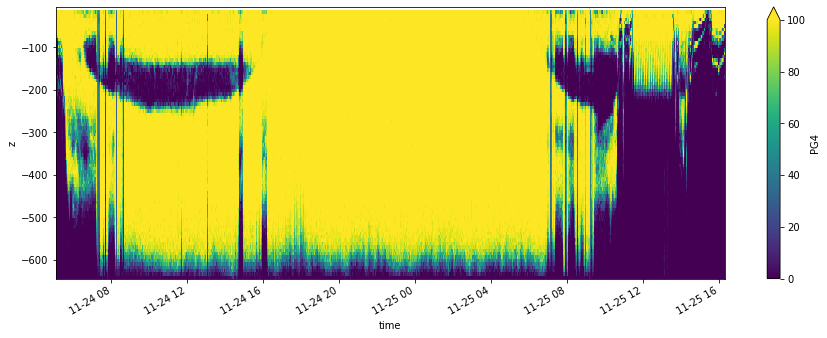

In [8]:
adcp_file = cp.path+'adcp/sta/087_sta.txt'
ds = read_adcp(adcp_file)
ds['PG4'].plot(vmax=100, figsize=(15,5))

In [9]:
ds = xr.concat([read_adcp(cp.path+'adcp/sta/0{}_sta.txt'.format(n)) 
                for n in range(84,88)
               ],
               'time'
              )
#ds = ds.where( (ds['PG4']>50) )

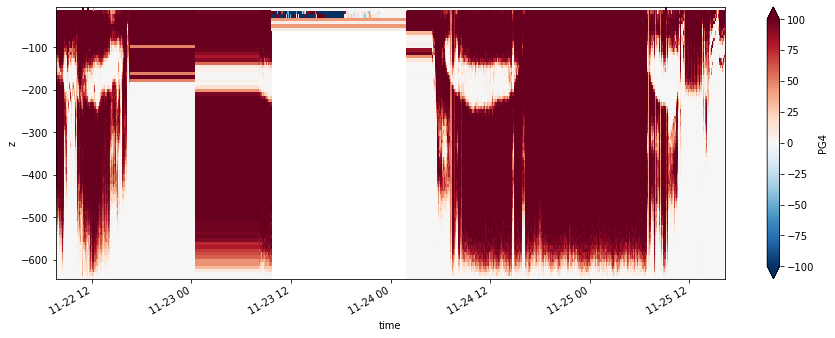

In [10]:
ds['PG4'].plot(vmax=100, figsize=(15,5))

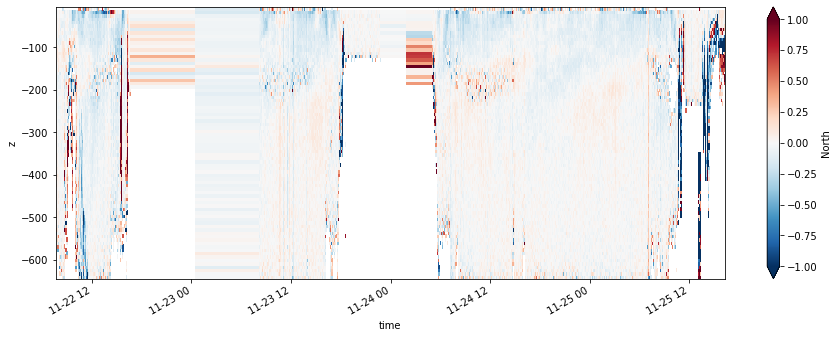

In [11]:
ds['North'].plot(vmax=1., figsize=(15,5))

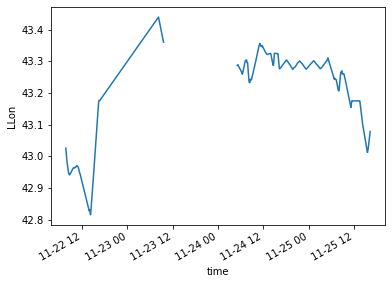

In [140]:
ds['LLon'].plot()

In [10]:
cp['mvp']

In [47]:
ds

<xarray.Dataset>
Dimensions:  (time: 1768, z: 80)
Coordinates:
  * z        (z) float64 -640.5 -632.5 -624.5 -616.5 ... -24.48 -16.48 -8.48
  * time     (time) datetime64[ns] 2020-11-22T07:39:19 ... 2020-11-25T16:18:43
Data variables:
    East     (z, time) float64 -0.062 0.108 0.115 0.107 ... -0.137 -0.131 0.009
    North    (z, time) float64 0.17 0.147 0.169 0.161 ... 0.0 0.0 0.077 0.012
    Ver      (z, time) float64 1.0 -28.0 -13.0 -45.0 -8.0 ... nan nan nan nan
    Err      (z, time) float64 95.0 0.0 0.0 0.0 0.0 17.0 ... nan nan nan nan nan
    PG4      (z, time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    NVE      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    NVN      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    FLat     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    FLon     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    LLat     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    LLon     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

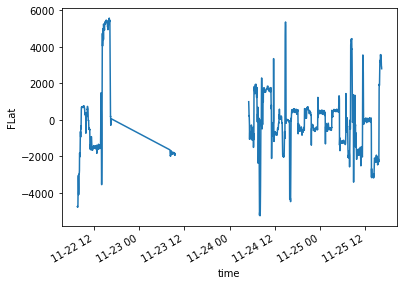

In [142]:
ds['FLat'].plot()

In [109]:
ds['LLon']

<xarray.DataArray 'LLon' (time: 41)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2020-11-23T08:13:25 ... 2020-11-23T09:33:25

In [98]:
ds['NVE'] = df['NVE']

In [103]:
ds.assign({'NVE': df['NVE']}).reset_coords('NVE')

<xarray.Dataset>
Dimensions:  (time: 41, z: 80)
Coordinates:
  * time     (time) datetime64[ns] 2020-11-23T08:13:25 ... 2020-11-23T09:33:25
  * z        (z) float64 -640.5 -632.5 -624.5 -616.5 ... -24.48 -16.48 -8.48
Data variables:
    EAA      (z, time) int64 14 14 15 14 14 14 14 13 13 14 ... 0 0 0 3 3 3 3 3 3
    C5       (z, time) int64 116 124 118 108 112 84 116 ... 13 13 13 13 13 13 13
    East     (z, time) float64 -0.45 -0.022 0.171 0.359 ... 0.084 0.09 0.098
    North    (z, time) float64 -0.014 -0.027 0.109 ... 0.233 -0.046 -0.215
    Err      (z, time) int64 100 100 100 100 100 100 ... 56 -180 192 -53 -197 22
    PG4      (z, time) float64 7.171 43.44 7.175 43.44 ... 100.0 100.0 100.0
    NVE      (time) float64 43.44 7.173 43.44 7.177 ... 43.37 43.36 43.36 nan

In [83]:
ds = ds.where( (ds['PG4']>50) )
#ds = ds.where( (ds['PG4']>50) & (ds['PG4']<100) )

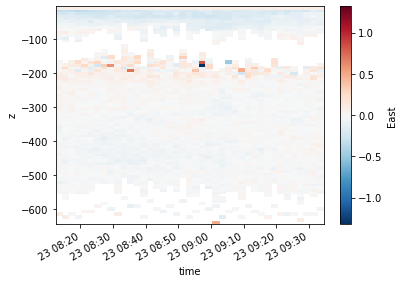

In [84]:
ds['East'].plot()

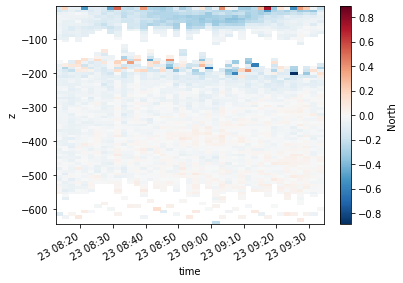

In [85]:
ds['North'].plot()

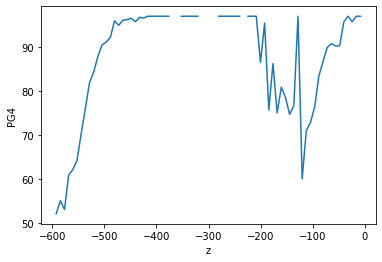

In [79]:
ds['PG4'].mean('time').plot()

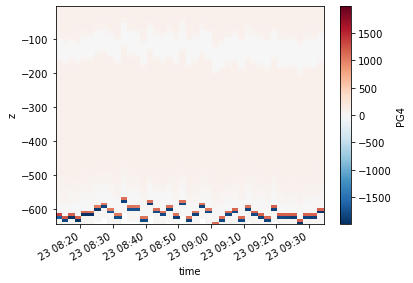

In [75]:
ds['PG4'].plot()

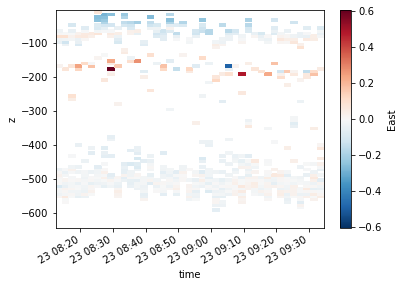

In [80]:
ds['East'].plot()

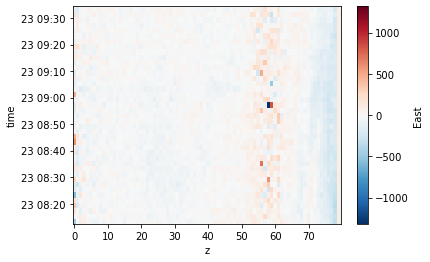

In [49]:
ds['East'].plot()

In [45]:
ds = df.to_xarray()
ds

<xarray.Dataset>
Dimensions:  (level_1: 80, time: 41)
Coordinates:
  * time     (time) datetime64[ns] 2020-11-23T08:13:25 ... 2020-11-23T09:33:25
  * level_1  (level_1) float64 -640.5 -632.5 -624.5 ... -24.48 -16.48 -8.48
Data variables:
    EAA      (time, level_1) int64 14 15 15 15 15 16 16 ... 78 79 80 84 94 113 3
    C5       (time, level_1) int64 116 122 126 138 147 ... 228 221 225 212 13
    East     (time, level_1) int64 -450 -7 102 83 -23 31 ... -82 -74 -64 -216 98
    North    (time, level_1) int64 -14 -12 62 -116 9 ... -51 -56 -35 -124 -215
    Err      (time, level_1) int64 100 100 100 97 83 79 21 ... 9 2 -19 1 -5 22
    PG4      (time, level_1) float64 7.171 43.44 -1.644e+03 ... 100.0 100.0

In [6]:
# read ADCP data
adcp_file = cp.path+'adcp/cognac20_22112020_bin3.txt'

In [41]:
def read_adcp_1bin(adcp_file, resampling='2T'):
    df = pd.read_csv(adcp_file,
                        sep='\t+', 
                        skiprows=16, 
                        names=['Ens',
                               'YR', 'MO', 'DA', 'HH', 'MM', 'SS', 'HHbis', 
                               'Eas', 'Nor', 
                               'PG4', 
                               'NVE', 'NVN', 
                               'FLat', 'FLon',
                               'LLat', 'LLon',
                              ],
                     decimal=',',
                     index_col=False,
                     )
    # rescale velocity
    for u in ['Eas', 'Nor', 'NVE', 'NVN']:
        df[u] = df[u]/1e3

    df['time'] = pd.Series(
                            [pd.Timestamp(year=int(2000+row['YR']), 
                              month=int(row['MO']),
                              day=int(row['DA']),
                              hour=int(row['HH']),
                              minute=int(row['MM']),
                              second=int(row['SS']),
                             ) for _,row in df.iterrows()]
                        )
    df = df.set_index('time')

    if resampling is not None:
        df = df.resample(resampling).mean()
    
    return df

def plot_current(df, lims=None, scale=10):

    if lims==0:
        ll_lims = [6.3, 6.8, 42.75, 43.2]
    else:
        ll_lims = [7., 7.3, 43.3, 43.5]
    
    x, y, u, v = df['FLon'], df['FLat'], df['Eas'], df['Nor']
    fac = insi.utils.plot_map(cp=cp, ll_lim=ll_lims)
    insi.utils.plot_bathy(fac)
    q = fac[1].quiver(x, y, u, v, transform=fac[2], scale=scale)

    qk = plt.quiverkey(q, 0.1, 0.1, 0.5,
                       'velocity (0.5 m s$^{-1}$)',
                       labelpos='E',
                       transform=fac[2],
                       color='r')    

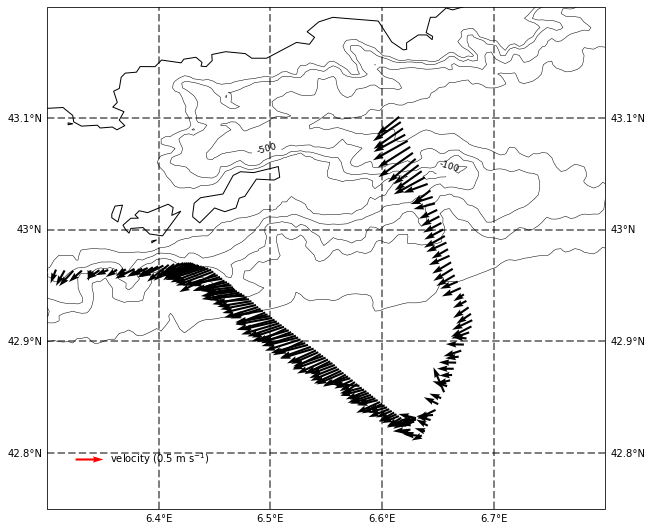

In [25]:
df = read_adcp_1bin(adcp_file)
plot_current(df, lims=0)

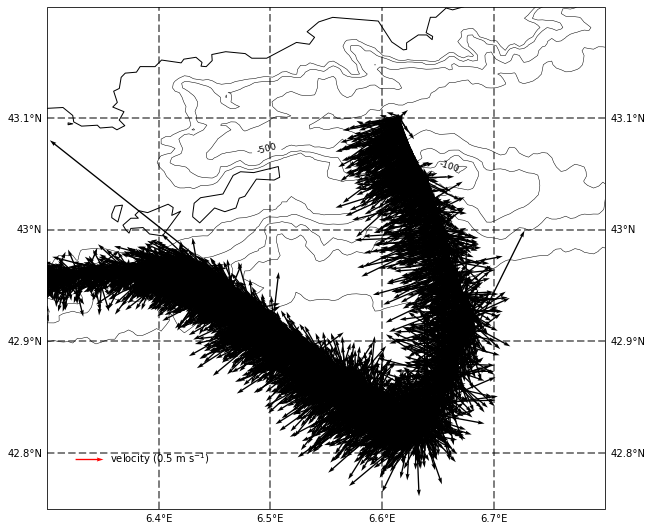

In [26]:
df = read_adcp_1bin(adcp_file, resampling=None)
plot_current(df, lims=0)

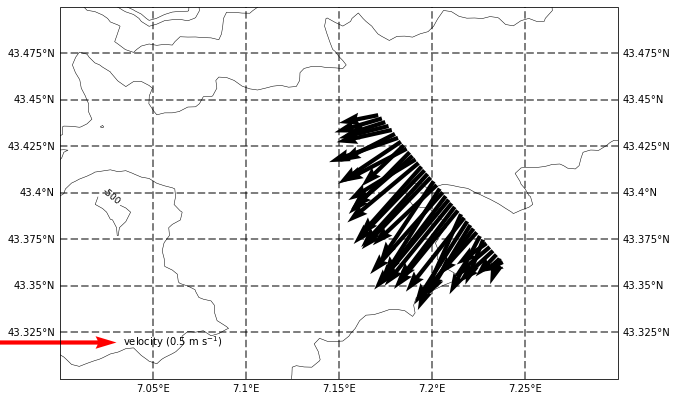

In [45]:
adcp_file = cp.path+'adcp/cognac20_23112020_bin3_0sta.txt'
df = read_adcp_1bin(adcp_file, resampling=None)
plot_current(df, scale=2)

In [31]:
df

,Ens,YR,MO,DA,HH,MM,SS,HHbis,Eas,Nor,PG4,NVE,NVN,FLat,FLon,LLat,LLon
time,,,,,,,,,,,,,,,,,
2020-11-23 08:12:00,7.0,20.0,11.0,23.0,8.0,13.0,40.0,0.0,2.847385,-3.190000,100.0,1.347769,-1.418000,43.441545,7.171356,43.441506,7.171410
2020-11-23 08:14:00,33.5,20.0,11.0,23.0,8.0,14.5,29.5,0.0,2.713925,-3.363925,100.0,1.281225,-1.727700,43.440355,7.172691,43.440324,7.172722
2020-11-23 08:16:00,73.5,20.0,11.0,23.0,8.0,16.5,29.5,0.0,2.682825,-3.594075,100.0,1.214175,-1.847875,43.438422,7.174513,43.438389,7.174543
2020-11-23 08:18:00,113.5,20.0,11.0,23.0,8.0,18.5,29.5,0.0,2.730875,-3.773050,100.0,1.187900,-1.981775,43.436355,7.176275,43.436319,7.176304
2020-11-23 08:20:00,153.5,20.0,11.0,23.0,8.0,20.5,29.5,0.0,2.724200,-3.706050,100.0,1.177775,-1.945025,43.434223,7.178028,43.434188,7.178058
2020-11-23 08:22:00,193.5,20.0,11.0,23.0,8.0,22.5,29.5,0.0,2.651850,-3.678600,100.0,1.120950,-1.958150,43.432123,7.179753,43.432087,7.179781
2020-11-23 08:24:00,233.5,20.0,11.0,23.0,8.0,24.5,29.5,0.0,2.698825,-3.691300,100.0,1.115075,-1.999275,43.429991,7.181400,43.429955,7.181427
2020-11-23 08:26:00,273.5,20.0,11.0,23.0,8.0,26.5,29.5,0.0,2.524375,-3.456900,100.0,1.029350,-1.875500,43.427883,7.182976,43.427848,7.183001
2020-11-23 08:28:00,313.5,20.0,11.0,23.0,8.0,28.5,29.5,0.0,2.453975,-3.236650,100.0,1.053700,-1.752275,43.425913,7.184535,43.425882,7.184561


--- 
## store

In [16]:
ds = df.to_xarray()
ds.to_netcdf(cp.pathp+'ship.nc')

In [18]:
# reload
df = xr.open_dataset(cp.pathp+'ship.nc').to_dataframe()
df.head()

,gndcourse,depth,heading,alt,lat,lon,gndspeed,trueairheading,watertemp,airpressure,...,airtemp,moisture,relairheading,salinity,temp,conduct,density,intaketemp,sndspeed,fluor
time,,,,,,,,,,,,,,,,,,,,,
2020-11-22 08:40:00,96.752998,857.619995,95.577904,0.0,42.941458,6.018699,8.306,341.200012,17.700001,1028.800049,...,14.10,58.799999,317.600006,37.978352,17.4760,4.879635,27.71385,17.362499,1517.300049,0.361
2020-11-22 08:40:10,96.700996,838.179993,94.940697,0.0,42.941412,6.019229,8.439,333.799988,17.700001,1028.800049,...,14.04,58.920002,319.799988,37.978802,17.4760,4.879690,27.71410,17.363001,1517.300049,0.350
2020-11-22 08:40:20,96.613998,814.820007,95.650696,0.0,42.941368,6.019764,8.526,342.000000,17.700001,1028.800049,...,14.00,59.299999,320.600006,37.978203,17.4765,4.879685,27.71295,17.365499,1517.300049,0.350
2020-11-22 08:40:30,96.959000,800.640015,96.036400,0.0,42.941318,6.020298,8.551,345.799988,17.700001,1028.800049,...,14.00,59.860001,318.799988,37.977798,17.4785,4.879900,27.71245,17.366001,1517.300049,0.357
2020-11-22 08:40:40,97.477997,775.059998,95.845596,0.0,42.941266,6.020831,8.523,351.000000,17.700001,1028.800049,...,14.00,60.200001,322.200012,37.978699,17.4800,4.880100,27.71330,17.365999,1517.300049,0.357
